## Install Dependencies

In [1]:
# ! pip install --quiet langchain_community tiktoken langchain-openai langchainhub  langchain langgraph tavily-python faiss-cpu

## Configure API Key

* See tavily API for web search [here](https://app.tavily.com/sign-in)

In [2]:
# Check API keys
# https://app.tavily.com/sign-in

import os
tavily_api_key = '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'

## Download OLlama and llama2


Download Ollama from here: [Ollama](https://python.langchain.com/docs/langgraph): 


In [3]:
local_llm = "llama2:latest"

## Indexing

First, let's index a popular model Sora's blog post.

We'll use a local vectorstore FAISS

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [5]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma,FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter



# Load
url = "https://openai.com/sora"
loader = WebBaseLoader(url)
docs = loader.load()

DB_FAISS_PATH = 'vectorstore/db_faiss'

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=100
)
all_splits = text_splitter.split_documents(docs)

# Embed and index    
embedding = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2',
                                       model_kwargs={'device': 'cpu'})

# Index
vectorstore = FAISS.from_documents(
    documents=all_splits,
    embedding=embedding
)

vectorstore.save_local(DB_FAISS_PATH)

retriever = vectorstore.as_retriever(search_kwargs={'k': 6})

## Corrective RAG

Let's implement self-reflective RAG with some ideas from the CRAG (Corrective RAG) [paper](https://arxiv.org/pdf/2401.15884.pdf):

* Grade documents for relevance relative to the question.
* If any are irrelevant, then we will supplement the context used for generation with web search.
* For web search, we will re-phrase the question and use Tavily API.
* We will then pass retrieved documents and web results to an LLM for final answer generation.

Here is a schematic of our graph in more detail:

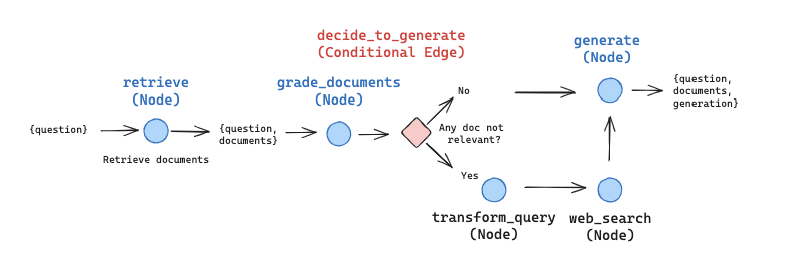

We will implement this using [LangGraph](https://python.langchain.com/docs/langgraph): 


---

### State

Every node in our graph will modify `state`, which is dict that contains values (`question`, `documents`, etc) relevant to RAG.

In [6]:
from typing import Annotated, Dict, TypedDict

from langchain_core.messages import BaseMessage


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        keys: A dictionary where each key is a string.
    """

    keys: Dict[str, any]

### Nodes and Edges

Every node in the graph we laid out above is a function.

Each node will modify the state in some way.

Each edge will choose which node to call next.

In [7]:
import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain import hub
from langchain_core.output_parsers import JsonOutputParser
from langchain.prompts import PromptTemplate
from langchain.schema import Document
from langchain_community.chat_models import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

### Nodes ###


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = retriever.get_relevant_documents(question)
    return {"keys": {"documents": documents, "question": question}}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains generation
    """
    print("---GENERATE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM

    llm = ChatOllama(model=local_llm, temperature=0)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {
        "keys": {"documents": documents, "question": question, "generation": generation}
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with relevant documents
    """

    print("---CHECK RELEVANCE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # LLM
    llm = ChatOllama(model=local_llm, format="json", temperature=0)

    #Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keywords related to the user question, grade it as relevant. \n
        It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
        Provide the binary score as a JSON with a single key 'score' and no premable or explaination.""",
        input_variables=["question", "context"],
    )

    chain = prompt | llm | JsonOutputParser()

    # Score
    filtered_docs = []
    search = "No"  # Default do not opt for web search to supplement retrieval
    for d in documents:
        score = chain.invoke(
            {
                "question": question,
                "context": d.page_content,
            }
        )
        grade = score["score"]
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            search = "Yes"  # Perform web search
            continue

    return {
        "keys": {
            "documents": filtered_docs,
            "question": question,
            "run_web_search": search,
        }
    }


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Create a prompt template with format instructions and the query
    prompt = PromptTemplate(
        template="""You are generating questions that is well optimized for retrieval. \n 
        Look at the input and try to reason about the underlying sematic intent / meaning. \n 
        Here is the initial question:
        \n ------- \n
        {question} 
        \n ------- \n
        Provide an improved question without any premable, only respond with the updated question: """,
        input_variables=["question"],
    )

    # Grader
    # LLM
    llm = ChatOllama(model=local_llm, temperature=0)

    # Prompt
    chain = prompt | llm | StrOutputParser()
    better_question = chain.invoke({"question": question})

    return {
        "keys": {"documents": documents, "question": better_question}
    }


def web_search(state):
    """
    Web search based on the re-phrased question using Tavily API.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Web results appended to documents.
    """

    print("---WEB SEARCH---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    tool = TavilySearchResults()
    docs = tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"keys": {"documents": documents, "question": question}}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer or re-generate a question for web search.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        str: Next node to call
    """

    print("---DECIDE TO GENERATE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    filtered_documents = state_dict["documents"]
    search = state_dict["run_web_search"]

    if search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: TRANSFORM QUERY and RUN WEB SEARCH---")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

## Build Graph

This just follows the flow we outlined in the figure above.

In [8]:
import pprint

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

In [9]:
# Run
inputs = {
    "keys": {
        "question": "What is Sora?"
    }
}

for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value["keys"]["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK RELEVANCE---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
"Node 'grade_documents':"
'\n---\n'
---DECIDE TO GENERATE---
---DECISION: GENERATE---
---GENERATE---
"Node 'generate':"
'\n---\n'
"Node '__end__':"
'\n---\n'
('\n'
 'Sora is an AI model developed by OpenAI that can generate videos from text '
 'instructions. The model uses a transformer architecture and represents '
 'videos and images as collections of smaller units of data called patches. '
 'Sora can generate videos up to a minute long while maintaining visual '
 "quality and adherence to the user's prompt.\n"
 '\n'
 'The model is trained on a wide range of visual data, including videos and '
 "images, and can follow the user's text instructions in the generated video "
 'more faithfully than previous models. Sora can also take an exis